In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

##### dataset

In [2]:
def gen_x0(n = 2,scale = 200,n_samples=128):
    x0 = 2*torch.rand(n_samples,n)-1
    x0 /= torch.sqrt(((x0)**2).sum(axis=1,keepdim=True))
    x0 *= torch.distributions.gamma.Gamma(concentration=scale,rate=scale).sample((n_samples,1))
    return x0

In [3]:
n_samples = 100000
X0 = gen_x0(n_samples = n_samples)

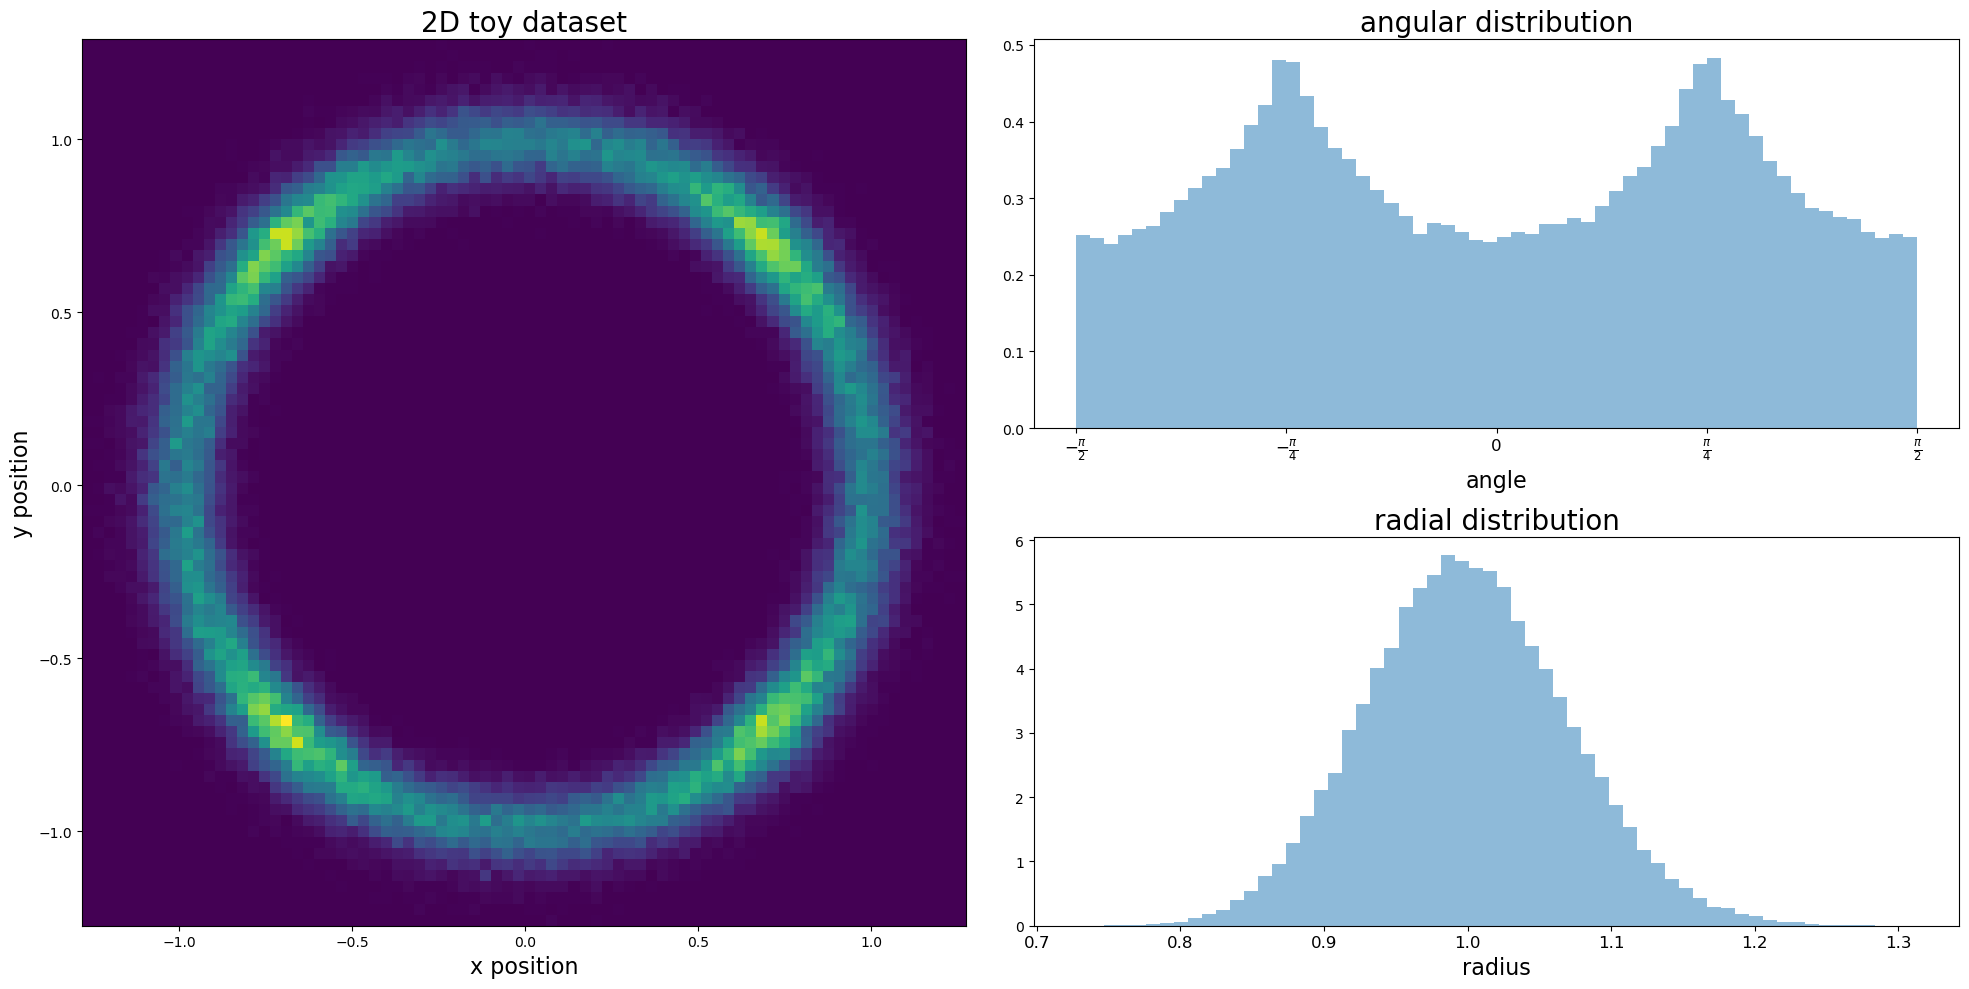

In [4]:
x = X0[:,0].detach().numpy()
y = X0[:,1].detach().numpy()

fig = plt.figure(figsize=(20,10))
gs = GridSpec(ncols=2,nrows=2,width_ratios=[1,1],height_ratios=[1,1])

ax = fig.add_subplot(gs[0:2,0])
_ = ax.hist2d(x = x, y = y,bins=80)
ax.set_aspect('equal')
ax.set_title('2D toy dataset',fontsize=20)
_ = ax.set_xlabel('x position',fontsize=16)
_ = ax.set_ylabel('y position',fontsize=16)

ax = fig.add_subplot(gs[0,1])
_ = ax.hist(np.arctan(y/x),bins=60,density=True,alpha=0.5)
# plt.gca().set_aspect('equal')
ax.set_title('angular distribution',fontsize=20)
ax.set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax.set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$'],fontsize=12)
ax.set_xlabel('angle',fontsize=16)

ax = fig.add_subplot(gs[1,1])
_ = ax.hist(np.sqrt(x**2 + y**2),bins=60,density=True,alpha=0.5)
# plt.gca().set_aspect('equal')
ax.set_title('radial distribution',fontsize=20)
ax.tick_params(axis='x', labelsize=12)
ax.set_xlabel('radius',fontsize=16)

fig.tight_layout()
# fig.savefig('toy-dataset.png')

##### parameters

In [25]:
beta_min = 0.1
beta_max = 20 
T = 1

##### forward process

In [19]:
def forward_x(x0,t):
    A = np.exp(-1/2*(beta_min*t + 1/(2*T)*(beta_max-beta_min)*t**2))
    B = np.sqrt(1-A**2)
    noise = torch.randn_like(x0)
    return A*x0 + B*noise, noise

In [22]:
x0 = torch.randn(2)
t = .1
forward_x(x0,t)

(tensor([0.8292, 0.1965]), tensor([1.2511, 0.7393]))

##### backward process

In [26]:
def sample_sde(score_net, batch_size = 128, dt = 5e-3):
    
    def beta(t):
        return beta_min + (beta_max-beta_min)*t/T

    def reverse_step(xt,t):
        tmat = (torch.ones_like(xt)*t)[...,:-1]
        xt_new = xt + (1/2*beta(t)*xt+ beta(t)*score_net(xt,tmat))*dt 
        xt_new += np.sqrt(beta(t))*torch.randn_like(xt)*np.sqrt(dt)
        return xt_new

    xt = torch.randn(batch_size,2)
    N = int(T/dt)
    for n in range(N,0,-1):
        xt = reverse_step(xt,n*dt)
        
    return xt

In [28]:
def dummy_score_net(xt,t):
    return xt

xts = sample_sde(batch_size=2,score_net = dummy_score_net)

##### neural network

In [29]:
class basic_net(nn.Module):
    def __init__(self, dim = 2, layer_size = 64, n_layers = 6):
        
        super().__init__()
        self.activ = nn.ReLU()

        self.layers = []
        self.layers.append(nn.Linear(dim+1,layer_size))
        for _ in range(n_layers-2):
            self.layers.append(nn.Linear(layer_size,layer_size))
        self.layers.append(nn.Linear(layer_size,dim))
        self.layers = nn.ModuleList(self.layers)

    def forward(self,x,t):

        xt = torch.cat((x,t),axis=-1)        
        for i, l in enumerate(self.layers[:-1]):
            xt = self.activ(l(xt))
        xt = self.layers[-1](xt)
    
        return xt

In [30]:
score_net = basic_net()
x = torch.randn(2)
t = torch.randn(1)
score_net(x,t)

tensor([ 0.1693, -0.0846], grad_fn=<AddBackward0>)

##### training phase

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')    

device = cuda


In [32]:
def A(t):
    return np.exp(-1/2*(beta_min*t + 1/(2*T)*(beta_max-beta_min)*t**2))

def B(t):
    return np.sqrt(1-A(t)**2)

n_epochs = 20000
n_batches = 1
batch_size = 5000
lr = 1e-3

score_net = basic_net()
optimizer = torch.optim.Adam(score_net.parameters(),lr=lr)
loss_f = nn.MSELoss()

i = 0
for n in range(n_epochs):
    for m in range(n_batches):
        
        x0 = gen_x0(n_samples = batch_size)
        t = T*torch.rand(batch_size,1)

        xt, noise = forward_x(x0,t)

        score_0 = -noise
        score_1 = B(t)*score_net(xt,t)
        loss = loss_f(score_0,score_1)
        
        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
        
        del x0,xt

        if i % 1000 == 0:
            print(f'{i}/{n_epochs*n_batches}: loss = {loss.detach().item()}')
            
        i+=1


0/20000: loss = 1.0111467838287354
1000/20000: loss = 0.20353829860687256
2000/20000: loss = 0.20356671512126923
3000/20000: loss = 0.1885492503643036
4000/20000: loss = 0.1796039193868637
5000/20000: loss = 0.17819470167160034
6000/20000: loss = 0.17703379690647125
7000/20000: loss = 0.18538568913936615
8000/20000: loss = 0.17660368978977203
9000/20000: loss = 0.17846761643886566
10000/20000: loss = 0.18058551847934723
11000/20000: loss = 0.178644061088562
12000/20000: loss = 0.17547789216041565
13000/20000: loss = 0.17640826106071472
14000/20000: loss = 0.1819095015525818
15000/20000: loss = 0.18893210589885712
16000/20000: loss = 0.17467819154262543
17000/20000: loss = 0.18328474462032318
18000/20000: loss = 0.1876242607831955
19000/20000: loss = 0.18080000579357147


###### evaluation

In [33]:
n_samples = 100000
X0 = gen_x0(n_samples = n_samples)

In [34]:
samples = sample_sde(batch_size = n_samples, score_net = score_net)
samples = samples.detach().numpy()

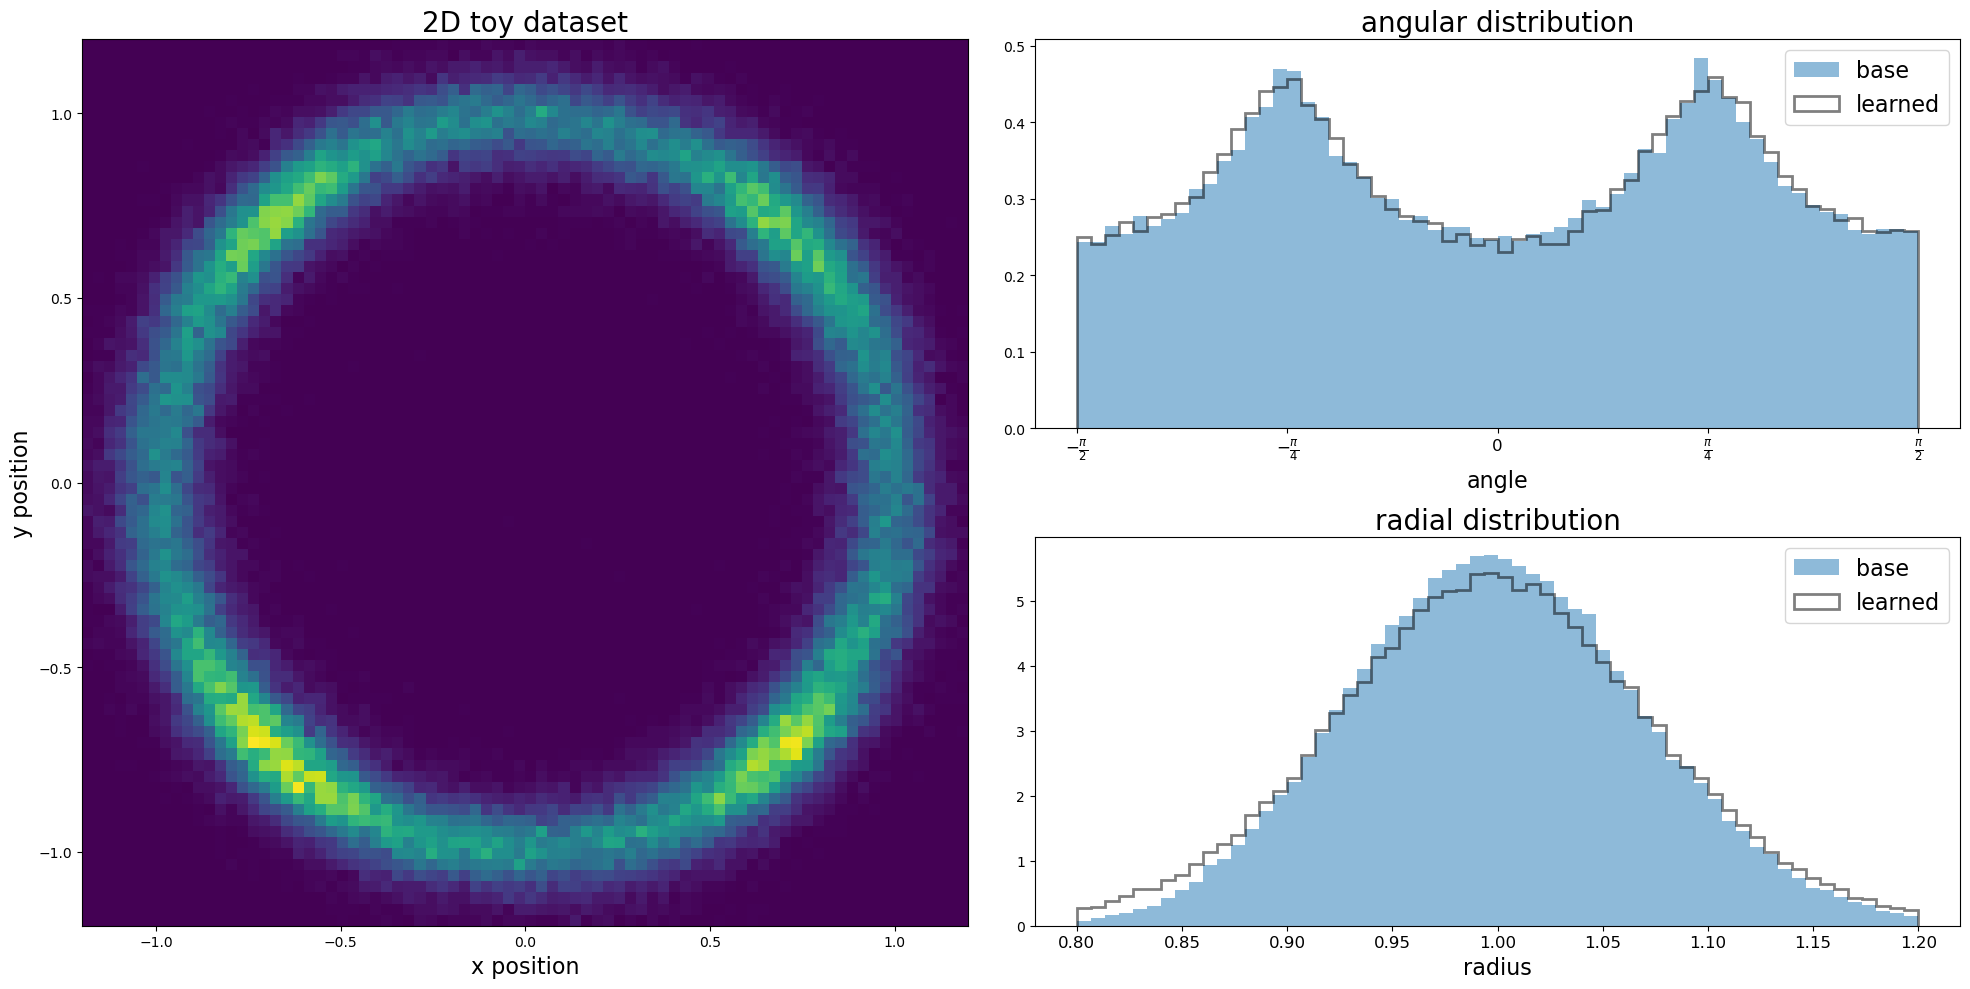

In [35]:
x = X0[:,0].detach().numpy()
y = X0[:,1].detach().numpy()

xx = samples[:,0]
yy = samples[:,1]

fig = plt.figure(figsize=(20,10))
gs = GridSpec(ncols=2,nrows=2,width_ratios=[1,1],height_ratios=[1,1])

ax = fig.add_subplot(gs[0:2,0])
_ = ax.hist2d(x = xx, y = yy,bins=80,range=[(-1.2,1.2),(-1.2,1.2)])
ax.set_aspect('equal')
ax.set_title('2D toy dataset',fontsize=20)
_ = ax.set_xlabel('x position',fontsize=16)
_ = ax.set_ylabel('y position',fontsize=16)

ax = fig.add_subplot(gs[0,1])
_ = ax.hist(np.arctan(y/x),bins=60,density=True,alpha=0.5,label='base')
_ = ax.hist(np.arctan(yy/xx),bins=60,density=True,alpha=0.5,histtype='step',lw=2,color='k',label='learned')
# plt.gca().set_aspect('equal')
ax.set_title('angular distribution',fontsize=20)
ax.set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax.set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$'],fontsize=12)
ax.set_xlabel('angle',fontsize=16)
ax.legend(fontsize=16)

ax = fig.add_subplot(gs[1,1])
_ = ax.hist(np.sqrt(x**2 + y**2),bins=60,density=True,alpha=0.5,label='base',range=(0.8,1.2))
_ = ax.hist(np.sqrt(xx**2 + yy**2),bins=60,density=True,alpha=0.5,histtype='step',lw=2,color='k',label='learned',range=(0.8,1.2))
# plt.gca().set_aspect('equal')
ax.set_title('radial distribution',fontsize=20)
ax.tick_params(axis='x', labelsize=12)
ax.set_xlabel('radius',fontsize=16)
ax.legend(fontsize=16)

fig.tight_layout()
# fig.savefig('learned-dataset.png')